In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [2]:
from IPython.display import clear_output

In [3]:
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split

def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    mnist = fetch_mldata('MNIST original')
    data = mnist['data'].reshape((70000, 28, 28, 1))
    target = mnist['target']
    # We can now download and read the training and test set images and labels.
    X_train, X_test, y_train, y_test = train_test_split(data, target, train_size=2000)
    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-300], X_train[-300:]
    y_train, y_val = y_train[:-300], y_train[-300:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

print("Loading data...")
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
total_size = X_train.shape[0]

Loading data...


/home/nikita/.virtualenvs/py3.5/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [4]:
y_oh = OneHotEncoder(sparse=False)
y_oh.fit(y_train.reshape((-1,1)))
y_train, y_val, y_test = map(lambda x: y_oh.transform(x.reshape((-1,1))).astype('float32'), [y_train, y_val, y_test])

In [5]:
X_train, X_val, X_test = map(lambda x: (x.astype('float32') - 122)/255, [X_train, X_val, X_test])

In [6]:
y_val.shape

(300, 10)

In [7]:
X_val.dtype

dtype('float32')

In [8]:
def create_priorkl(pairs, prior_std):
    with tf.name_scope('KL'):
        for mu, sigma in pairs:
            kl = -tf.log(sigma) + (sigma**2 + mu**2)/(2*prior_std**2)
            kl = tf.reduce_sum(kl)
            tf.add_to_collection('KLS', kl)
            
def conv(x, nbfilter, filtersize, name, lrep=True):
    prior_std = 3
    
    s = int(x.shape[-2])
    
    input_f = int(x.shape[-1])
    kernelshape = [filtersize, filtersize, input_f, nbfilter]
    
    with tf.variable_scope(name, initializer=tf.random_normal_initializer(stddev=0.05)):
        with tf.name_scope(name+'/'):
            kernel_mu = tf.get_variable('kernel_mu', shape=kernelshape)
            kernel_sigma = tf.log1p(tf.exp(tf.get_variable('kernel_logsigma', shape=kernelshape) - 3))
            tf.summary.histogram('kernel_sigma', kernel_sigma)
            
            if lrep:
                pmu = tf.nn.conv2d(x, kernel_mu, [1,1,1,1], padding='SAME')
                pvar = tf.nn.conv2d(x**2, kernel_sigma**2, [1,1,1,1], padding='SAME')
                p = tf.random_normal(tf.shape(pmu))*tf.sqrt(pvar) + pmu
            else:
                kernel = tf.random_normal(tf.shape(kernel_mu))*kernel_sigma + kernel_mu
                p = tf.nn.conv2d(x, kernel, [1,1,1,1], padding='SAME')
                
            bias_mu = tf.get_variable('bias_mu', shape=[1,1,1,nbfilter])
            bias_sigma = tf.log1p(tf.exp(tf.get_variable('bias_logsigma', shape=[1,1,1,nbfilter]) - 3))
            
            create_priorkl([[kernel_mu, kernel_sigma], [bias_mu, bias_sigma]], prior_std)
            
            p += tf.random_normal(tf.shape(bias_mu))*bias_sigma + bias_mu
            
            p = tf.nn.relu(p)
            p.set_shape([None,s,s,nbfilter])
            return p
        
def dense(x, nneurons, name, act=tf.nn.relu, lrep=True):
    prior_std=3
    input_n = int(x.shape[-1])
    Wshape = [input_n, nneurons]
    with tf.variable_scope(name, initializer=tf.random_normal_initializer(stddev=0.05)):
        with tf.name_scope(name+'/'):
            W_mu = tf.get_variable('kernel_mu', shape=Wshape)
            W_sigma = tf.log1p(tf.exp(tf.get_variable('kernel_logsigma', shape=Wshape) - 3))
            tf.summary.histogram('W_sigma', W_sigma)
            
            b_mu = tf.get_variable('bias_mu', shape=[1,nneurons])
            b_sigma = tf.log1p(tf.exp(tf.get_variable('bias_logsigma', shape=[1,nneurons]) - 3))
            
            create_priorkl([[W_mu, W_sigma], [b_mu, b_sigma]], prior_std)
            
            if lrep:
                p_mu = tf.matmul(x, W_mu)
                p_sigma = tf.sqrt(tf.matmul(x**2, W_sigma**2))
                
                p = tf.random_normal(tf.shape(p_mu))*p_sigma + p_mu
            else:
                W = tf.random_normal(tf.shape(W_mu))*W_sigma + W_mu
                p = tf.matmul(x, W)
                
            p += tf.random_normal(tf.shape(b_mu))*b_sigma + b_mu
            p = act(p)
            
            p.set_shape([None, nneurons])
            return p

In [9]:
x_inp = tf.placeholder(tf.float32, [None,28,28,1])
y_inp = tf.placeholder(tf.float32, [None,10])

lrep = True
x = conv(x_inp, 40, 5, 'c1', lrep=lrep)
x = tf.nn.max_pool(x, (1,2,2,1), [1,2,2,1], 'SAME')
    
x = conv(x, 40, 5, 'c4', lrep=lrep)
x = tf.nn.max_pool(x, (1,2,2,1), [1,2,2,1], 'SAME')
    
x = conv(x, 20, 3, 'c5', lrep=lrep)  
x = tf.reshape(x, [-1, (int(x.shape[-2])**2)*int(x.shape[-1])])

x = dense(x, 20, 'd1', lrep=lrep)
x = dense(x, 10, 'd2', act=lambda x: x, lrep=lrep)

In [10]:
output = tf.nn.softmax(x)

In [11]:
batchsize = 50
kls = tf.get_collection('KLS')
l1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=x, labels=y_inp))
l2 = batchsize*sum(kls)/len(X_train)
loss = l1 + l2

In [12]:
loss /= 500

In [13]:
def gtop(loss):
    with tf.name_scope('optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        gvs = optimizer.compute_gradients(loss)
        capped_gvs = [(tf.clip_by_value(grad, -100., 100.), var) for grad, var in gvs if grad is not None]
        train_op = optimizer.apply_gradients(capped_gvs)
        return train_op

train_op = gtop(loss)

In [14]:
def train(X, y):
    return sess.run([loss, train_op], {x_inp:X, y_inp:y})[0]

def evaluate(X, y):
    nsamples = 20
    pred = np.zeros([len(y), 10])
    for _ in range(nsamples):
        pred += sess.run(output, {x_inp:X})
    return np.mean(np.argmax(pred, axis=-1) == np.argmax(y, axis=-1))

def eval_loss(X, y):
    return loss_sum.eval({x_inp:X, y_inp:y})

In [15]:
hist_sum = tf.summary.merge_all()

In [16]:
loss_sum = tf.summary.merge([tf.summary.scalar('logprob', l1), 
                             tf.summary.scalar('kl', l2), 
                             tf.summary.scalar('ELBO', loss)])

In [17]:
!rm -R /tmp/bayes_mnist/

In [18]:
writer = tf.summary.FileWriter('/tmp/bayes_mnist')

In [19]:
writer.add_graph(tf.get_default_graph())

In [20]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [21]:
sess.run([loss], {x_inp:X_val, y_inp:y_val})

[12.126312]

In [22]:
%time evaluate(X_val, y_val)

CPU times: user 51.1 s, sys: 6.57 s, total: 57.7 s
Wall time: 4.98 s


0.10000000000000001

In [23]:
%time evaluate(X_train, y_train)

CPU times: user 4min 51s, sys: 23.8 s, total: 5min 15s
Wall time: 26.8 s


0.12529411764705883

In [24]:
losses = []
accs = []

In [ ]:
epoch = 0

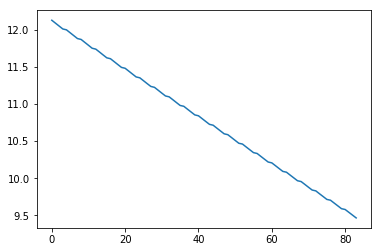

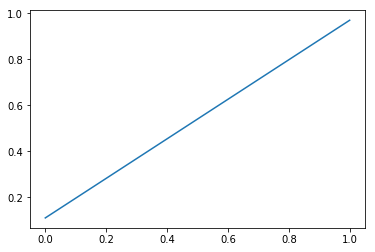

In [ ]:
for epoch in range(epoch, 10000):
    for ix in range(len(X_train)//batchsize - 1):
        ix0 = ix*batchsize
        ix1 = (ix+1)*batchsize
        X, y = X_train[ix0:ix1], y_train[ix0:ix1]
        loss_ = train(X,y)
        
        if ix % 10 == 0:
            losses.append(loss_)
        
    if epoch % 20 == 0:
        writer.add_summary(hist_sum.eval(), global_step=epoch)
        writer.add_summary(eval_loss(X,y), global_step=epoch)
        
        accs.append(evaluate(X_val, y_val))

        clear_output()
        plt.plot(range(len(losses)), losses)
        plt.show()
        plt.plot(range(len(accs)), accs)
        plt.show()